In [5]:
from CNN_musical.CNN_musical import ModeloCNN, fit
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [1]:
from utils import utils

In [18]:
utils.separar("./datos_nuevos/Piano2.wav", "datos_nuevos/prueba/", 2)

In [ ]:
import CNN_musical

In [2]:
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# data_dir = "../data/spectrograms"
data_dir = "data/MelSpectrograms/"

#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [3]:
#No ejectutar si vamos a cargar el modelo
num_epochs = 7
opt_func = torch.optim.Adam
lr = 0.001

model = ModeloCNN(device)
#fitting the model on training data and record the result after each epoch

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [4]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 32
val_size = 580
test_size = 300
train_size = len(dataset) - (val_size + test_size)

train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")


#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

Length of Train Data : 3216
Length of Validation Data : 580
Length of Test Data : 300


# Cargar el modelo y predecir

In [3]:
# Cargamos el modelo y lo devolvemos a partir de un fichero que se encuentra 
# en la ruta = <ruta> y el device lo ajustamos al que tengamos
def cargarModelo(ruta, device):
    model = ModeloCNN(device)
    model.load_state_dict(torch.load(ruta, map_location=device))
    return model

In [6]:
ruta = "../trainedModelNoHistory.pth"
device = torch.device('cpu')

model = cargarModelo(ruta, device)

In [7]:
# Hacemos un predict sobre un input y devolvemos el índice de clase predicho
def single_predict(model, input):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        predicted_index = predictions[0].argmax(0)
    return predicted_index.item()

In [8]:
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder

# Tratamos de predecir el audio en espectrogramas, donde tiene las imagenes en <data_dir/espectrogramas>
# De nuevo, ajustamos el device al que tengamos disponible

def predict(model, data_dir, device):
    dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
    ]))
    data=DataLoader(dataset, 1, num_workers = 4, pin_memory = True)

    predicciones = []
    for batch in data:
        indicePredicho=single_predict(model,batch[0].to(device))
        predicciones.append(indicePredicho)
    
    return predicciones

In [9]:
# Tratamos de devolver el índice que más veces ha predicho, ya que habrá veces que prediga mal
def most_common(predicciones):
    return max(set(predicciones), key=predicciones.count)

In [19]:
# Celda de prueba

instrumentos = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'vocal']

ruta = "./datos_nuevos/"

# Generamos las predicciones que se encuentren en la ruta <ruta> y vemos qué prediccion ha sido la más común
predicciones = predict(model, ruta, device)

instrumentos_predicciones = [instrumentos[i] for i in predicciones]

print(instrumentos_predicciones)

prediccionFinal = most_common(predicciones)

# Mostramos qué intrumento ha predicho
print(instrumentos[prediccionFinal])

['bass', 'bass', 'organ', 'organ', 'organ', 'organ', 'bass', 'bass', 'bass']
bass


# Prueba de ver onSet

In [15]:
import librosa

[0.06965986 0.74303855 3.13469388 3.39011338 3.83129252 3.92417234
 4.2492517  4.36535147 4.5046712  6.22294785 6.40870748 9.0093424
 9.07900227 9.28798186]


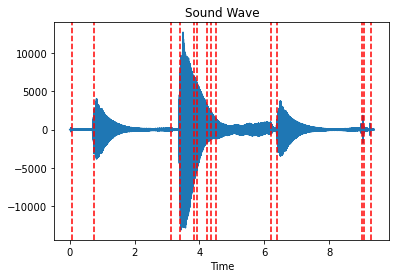

In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
import wave, sys

def ver_onSet(audio):
    y, sr = librosa.load(audio)
    array_tiempos = librosa.onset.onset_detect(y=y, sr=sr, units='time')
    return array_tiempos

# shows the sound waves
def visualize(path: str):

	# reading the audio file
	raw = wave.open(path)

	# reads all the frames
	# -1 indicates all or max frames
	signal = raw.readframes(-1)
	signal = np.frombuffer(signal, dtype ="int16")
	
	# gets the frame rate
	f_rate = raw.getframerate()

	# to Plot the x-axis in seconds
	# you need get the frame rate
	# and divide by size of your signal
	# to create a Time Vector
	# spaced linearly with the size
	# of the audio file
	time = np.linspace(
		0, # start
		len(signal) / (2*f_rate),
		num = len(signal)
	)

	# using matplotlib to plot
	# creates a new figure
	plt.figure(1)
	
	# title of the plot
	plt.title("Sound Wave")
	
	# label of x-axis
	plt.xlabel("Time")
	
	# actual plotting
	plt.plot(time, signal)
	
	for xc in tiempos_onset:
		plt.axvline(x=xc, color='red', linestyle='--')
    
	# shows the plot
	# in new window
	plt.show()

	# you can also save
	# the plot using
	# plt.savefig('filename')


if __name__ == "__main__":
    audio = './datos_nuevos/Piano2.wav'
    tiempos_onset = ver_onSet(audio)

    print(tiempos_onset)
    path = os.path.join(os.getcwd(),audio)
    visualize(path)